In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from operator import add
import nltk
import json
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')



In [2]:
# ta bort
#confSpark = SparkConf().set("spark.driver.bindAddress", "localhost")
#sc = SparkContext("local[*]", "appname", conf = confSpark)

"""# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.119:7077") \
        .appName("TestApp")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.executor.cores",2)\
        .getOrCreate()


# Old API (RDD)
spark_context = spark_session.sparkContext

spark_context.setLogLevel("INFO")"""
conf = SparkConf()
conf.setMaster('spark://192.168.2.119:7077')
conf.setAppName('YEEHAW2')
spark_context = SparkContext(conf=conf)

In [3]:
"""rdd = spark_context.newAPIHadoopFile(
    'RC_2005-12',
    'org.apache.hadoop.mapreduce.lib.input.TextInputFormat',
    'org.apache.hadoop.io.LongWritable',
    'org.apache.hadoop.io.Text'
)\
.cache()"""
#hdfs://localhost:9000
rdd = spark_context.newAPIHadoopFile(
    'hdfs://localhost:9000/user/ubuntu/RC_2006-02',
    'org.apache.hadoop.mapreduce.lib.input.TextInputFormat',
    'org.apache.hadoop.io.LongWritable',
    'org.apache.hadoop.io.Text'
)

In [4]:
rdd.take(3)

[(0,
  '{"created_utc":1138752114,"author_flair_css_class":null,"score":0,"ups":0,"subreddit":"reddit.com","stickied":false,"link_id":"t3_15xh","subreddit_id":"t5_6","body":"THAN the title suggests.  Whoops.","controversiality":1,"retrieved_on":1473820870,"distinguished":null,"gilded":0,"id":"c166b","edited":false,"parent_id":"t3_15xh","author":"gmcg","author_flair_text":null}'),
 (372,
  '{"author_flair_text":null,"author":"joshuaknox","id":"c166d","parent_id":"t3_15tx","edited":false,"gilded":0,"retrieved_on":1473820870,"distinguished":null,"controversiality":0,"body":"Thank you, willis3000.  This seems to be bunk:  self-discipline doesn\'t standard-deviation out well.  How do you measure it?   It, unlike IQ, is highly subjective, and non-controversial.  \\r\\n\\r\\nPerhaps more importantly, a two year study of eighth graders is just crap.   If they check back in in twenty years or so, this would perhaps have a shred of validity, but not a heck of a lot happens with eighth graders.  

In [5]:
print(rdd.count())

9095


In [7]:
gram_groups = dict()
gram_groups['Adjectives'] = ['JJ', 'JJR', 'JJS']
gram_groups['Nouns'] = ['NN', 'NNS', 'NNP', 'NNPS']
gram_groups['Pronouns'] = ['PRP', 'PRP$']
gram_groups['Adverbs'] = ['RB', 'RBR', 'RBS']
gram_groups['Verb'] = ['VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ']

In [8]:
def get_split_body(rdd):
    body = rdd\
    .map(lambda line: json.loads(line[1])['body'].strip().split())\

    return body

def check_gram_grp(tag_tuple):
    word, tag = tag_tuple
    for supergroup, subgroups in gram_groups.items():
                if tag in subgroups:
                    return supergroup
    return None

def categorize_words(split_rdd):
    cat_words = split_rdd.flatMap(lambda word: nltk.pos_tag(word))\
    .map(lambda tupl: (check_gram_grp(tupl), 1))\
    .filter(lambda x: x[0] != None)
   
    return cat_words

In [9]:
split = get_split_body(rdd)
categorized = categorize_words(split)
group_counts = categorized.reduceByKey(add).collect()
print(group_counts)

[('Nouns', 105628), ('Verb', 67969), ('Adjectives', 33098), ('Pronouns', 23351), ('Adverbs', 20242)]


In [2]:
#group_counts = [('Nouns', 105628), ('Verb', 67969), ('Adjectives', 33098), ('Pronouns', 23351), ('Adverbs', 20242)]
total = sum([gram_grp[1] for gram_grp in group_counts])
group_counts_norm = [(x[0], x[1]/total) for x in group_counts]
print(total)

250288


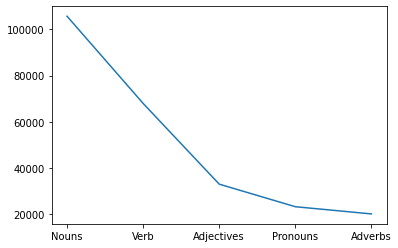

In [3]:
# plot of the grammatical classes
import matplotlib.pyplot as plt
grammatical_group = []
numbers = []
for gram_group, num in group_counts:
    grammatical_group.append(gram_group)
    numbers.append(num)
    
plt.plot(grammatical_group,numbers)
plt.show()

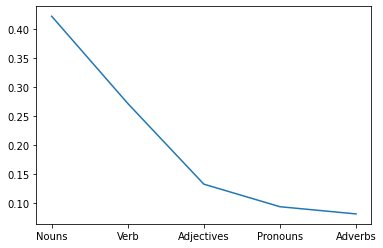

In [4]:
# divided with the total
gram_procentage = []
for num in numbers:
    gram_procentage.append(num/total)

plt.plot(grammatical_group,gram_procentage)
plt.show()

# En annan variant av plot ifall vi vill ha bar istället /Oscar

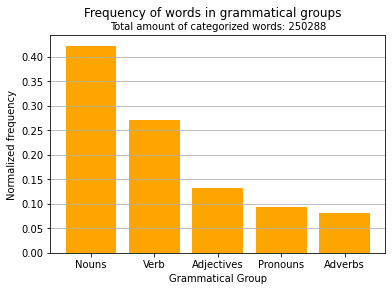

In [5]:
fig = plt.figure()
plt.bar(list(zip(*group_counts_norm))[0], list(zip(*group_counts_norm))[1], color='Orange')
plt.grid(axis='y')
plt.xlabel('Grammatical Group')
plt.ylabel('Normalized frequency')
plt.title(f'Total amount of categorized words: {total}',fontsize=10)
plt.suptitle("Frequency of words in grammatical groups")
plt.show()